In [ ]:
from mainnet_launch.pages.risk_metrics.estimate_exit_liquidity_from_pool_tvl import (
    _fetch_data,
    fetch_exit_liqudity_tvl,
    _compute_readable_exit_liquidity,
    combine_our_exposure_with_exit_liquidity,
)

from mainnet_launch.constants import *


chain = BASE_CHAIN
base_asset = USDC
refresh = False


# the problem is that for baseUSD only 3 rows are returned

# valid_dex_df

(
    valid_dex_df,
    all_chain_asset_exposure_df,
    our_token_to_total_other_token_liquidity,
    token_symbol_to_dfs,
    portion_ownership_by_destination_df,
    coingecko_prices,
) = fetch_exit_liqudity_tvl(chain, base_asset, refresh)

wide_exit_liquidity_df, total_usd_exit_liqudity_df, this_combination_exposure_df = _compute_readable_exit_liquidity(
    all_chain_asset_exposure_df,
    valid_dex_df,
    chain,
    base_asset,
)

exit_liquidity_and_exposure_df = combine_our_exposure_with_exit_liquidity(
    this_combination_exposure_df,
    total_usd_exit_liqudity_df,
    coingecko_prices,
)

In [4]:
valid_dex_df

,pairAddress,datetime_requested,datetime_received,chainId,dexId,url,priceNative,priceUsd,txns,volume,...,base_token_price_usd,quote_token_price_usd,base_token_usd_liquidity,quote_token_usd_liquidity,chain_id,reference_asset,tokemak_portion_ownership,tokemak_percent_ownership,scaled_quote_usd_liquidity,scaled_base_usd_liquidity
5,0x1A8944C4Ef25693922A5912D8E42eC831a12EB4c,2025-08-04 19:21:10.853756+00:00,2025-08-04 19:21:11.053006+00:00,base,pancakeswap,https://dexscreener.com/base/0x1a8944c4ef25693...,0.9946,0.9946,"{'m5': {'buys': 0, 'sells': 0}, 'h1': {'buys':...","{'h24': 23.98, 'h6': 10.89, 'h1': 2.3, 'm5': 0}",...,0.998935,0.999771,4.0,0.0,8453,0x833589fCD6eDb6E08f4c7C32D4f71b54bdA02913,0.0,0.0,0.0,4.0
8,0xFd4Ee9541833641e09472dac912900cAa776B5A6,2025-08-04 19:21:10.853906+00:00,2025-08-04 19:21:11.010743+00:00,base,pancakeswap,https://dexscreener.com/base/0xfd4ee9541833641...,0.9967,0.9967,"{'m5': {'buys': 0, 'sells': 0}, 'h1': {'buys':...","{'h24': 10.03, 'h6': 4.78, 'h1': 4.78, 'm5': 0}",...,0.998935,0.999771,56.0,43.0,8453,0x833589fCD6eDb6E08f4c7C32D4f71b54bdA02913,0.0,0.0,43.0,56.0
12,0xbaF56aeD39b4583c526971Ab51f8F2D4d8e59eb7,2025-08-04 19:21:10.854350+00:00,2025-08-04 19:21:11.011851+00:00,base,uniswap,https://dexscreener.com/base/0xbaf56aed39b4583...,0.9967,0.9967,"{'m5': {'buys': 0, 'sells': 0}, 'h1': {'buys':...","{'h24': 4965.35, 'h6': 3326.42, 'h1': 0, 'm5': 0}",...,0.998935,0.999771,454092.0,534921.0,8453,0x833589fCD6eDb6E08f4c7C32D4f71b54bdA02913,0.0,0.0,534921.0,454092.0


In [ ]:
# somewhere in the get_liquidity_quantities_of_many_pools
# we are missing the pools

In [5]:
coingecko_prices

{'0x6Bb7a212910682DCFdbd5BCBb3e28FB4E8da10Ee': 0.9989349745327911,
 '0x833589fCD6eDb6E08f4c7C32D4f71b54bdA02913': 0.9997705556841948}

In [ ]:
# dex screener just does not have curve here

In [14]:
from mainnet_launch.database.schema.ensure_tables_are_current.using_onchain.exit_liquidity.update_total_usd_exit_liqudity import (
    _fetch_pairs_with_prices,
    build_our_token_to_total_other_token_liquidity,
    _pure_function_group_destinations,
    get_portion_ownership_by_pool,
    _fetch_pairs_with_prices,
    _fetch_possible_pairs_from_dex_screener_and_coingecko,
)

In [10]:
this_chain_and_base_asset_exposure_df = all_chain_asset_exposure_df[
    (all_chain_asset_exposure_df["chain_id"] == chain.chain_id)
    & (all_chain_asset_exposure_df["reference_asset"] == base_asset(chain))
]

tokens_to_check_exit_liqudity_for = [
    t for t in this_chain_and_base_asset_exposure_df["token_address"].unique().tolist() if t != base_asset(chain)
]

tokens_to_check_exit_liqudity_for.append("0x417Ac0e078398C154EdFadD9Ef675d30Be60Af93")  # crvUSD on base

In [11]:
portion_ownership_by_destination_df = get_portion_ownership_by_pool(chain.client.eth.block_number, chain)
pool_to_portion_ownership = portion_ownership_by_destination_df.set_index("getPool")["portion_ownership"].to_dict()

valid_dex_df, coingecko_prices = _fetch_pairs_with_prices(  # this misses scrvUSD
    tokens_to_check_exit_liqudity_for, chain, base_asset
)

our_token_to_total_other_token_liquidity, token_symbol_to_dfs = build_our_token_to_total_other_token_liquidity(
    valid_dex_df, tokens_to_check_exit_liqudity_for
)

In [16]:
valid_pool_addresses = _fetch_possible_pairs_from_dex_screener_and_coingecko(tokens_to_check_exit_liqudity_for, chain)

In [17]:
valid_pool_addresses

['0xA61e143f9dA2a0C0a70d65fF322d84A1cc378006',
 '0x76501C056cA619903cB4D5c5BEAB7f4bc121cc42',
 '0xf6C5F01C7F3148891ad0e19DF78743D31E390D1f',
 '0x7F6095FECb6b67c08F1b8397701d666d71d703e0',
 '0x63d64A76C2D616676CBAC3068D3C6548F8485314',
 '0x773FdE6F33522d7A92775F2375AC76A6E6F279b7',
 '0x6e53131F68a034873b6bFA15502aF094Ef0c5854',
 '0x7d9bbD9073cd729Ce930b6ef0661a07e86Da76AD',
 '0x79F14303ca0eaa53e3D0a53F3355F678A08308bB',
 '0xdb83a2F984c33EBd1A293f9e422Fb0857bd4C263',
 '0x68446D5F287C5DfAaBfF932EFbEcDA2DD7e7861b',
 '0xc973042dcaF6FE4D632f2a9Cd624D38B9326BdE6',
 '0x798D81d60966d2E909468d87e7e4b6A8DAFB1C36',
 '0xB2fA79f6eca3F4ea78d5996430fE7d7c51fD6f80',
 '0x1A8944C4Ef25693922A5912D8E42eC831a12EB4c',
 '0x4DD5C0d33E949F641679d692Eb869E63caE7459e',
 '0xDE37E221442Fa15C35dc19FbAE11Ed106ba52fB2',
 '0xda3de145054ED30Ee937865D31B500505C4bDfe7',
 '0x9152996da3550D693600263C77142E5caBC144d2',
 '0x7F6095FECb6b67c08F1b8397701d666d71d703e0',
 '0xb9c79bD5e5561Bdcc281e2b530CeFBbeBC9976aC',
 '0xFd4Ee9541

In [ ]:
# coingecko *can* price crvUSD but not scrvUSD on base

# dex scr

In [12]:
coingecko_prices

{'0x417Ac0e078398C154EdFadD9Ef675d30Be60Af93': 0.9997791387559151,
 '0x6Bb7a212910682DCFdbd5BCBb3e28FB4E8da10Ee': 0.9989423768332627,
 '0x833589fCD6eDb6E08f4c7C32D4f71b54bdA02913': 0.9997784555744084}

In [ ]:
# https://www.curve.finance/dex/base/pools/factory-stable-ng-58/deposit/

In [ ]:
# there are truly no pools for scrvUSD on base, so we can't price it

# need to convert into crvUSD instead,

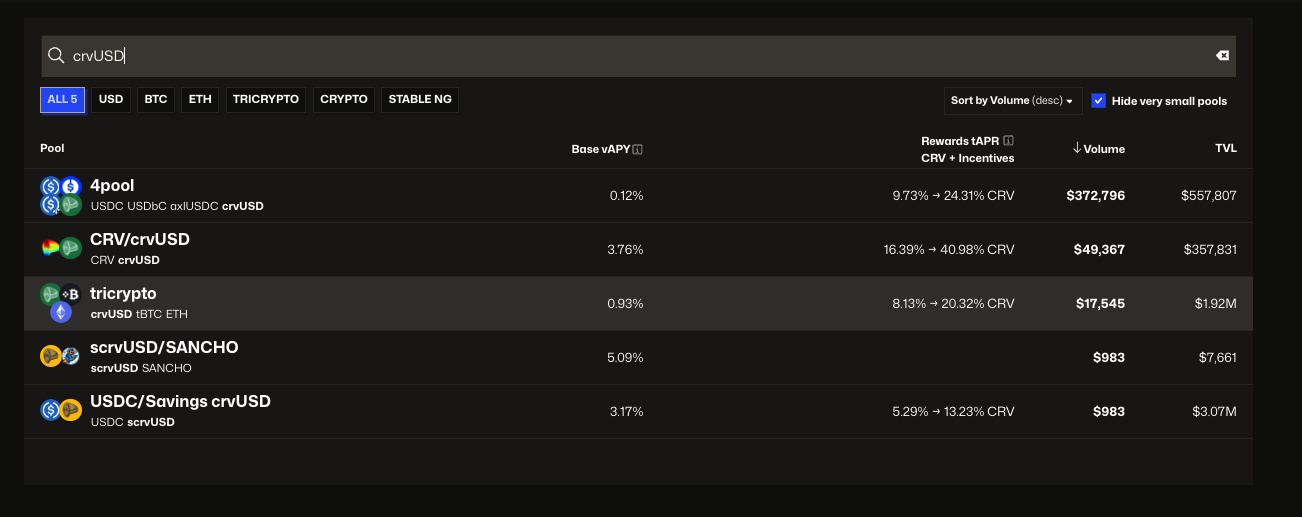

In [ ]:
# https://www.curve.finance/dex/base/pools/?search=crvUSD

In [ ]:
all_chain_asset_exposure_df[
    (all_chain_asset_exposure_df["chain_id"] == 8453) & (all_chain_asset_exposure_df["reference_symbol"] == "USDC")
]
# this is right

In [ ]:
# coingecko can't price scrvUSD on base?

In [ ]:
coingecko_prices

In [ ]:
# it's not properly pricing scrvUSD


# known issues:


# not properly pricing scrvUSD